# Interpolation 2D par élements finis

**cours master M1 mécanique: éléments finis (Marc BUFFAT, UCB Lyon 1)**

In [1]:
%matplotlib inline
import sys,os
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from random import random
from validation.validation import check_function
from validation.Maillage2D import Maillage
from IPython.display import display, Markdown, Latex
def printmd(string):
    display(Markdown(string))
# test si numero étudiant spécifier
try: NUMERO_ETUDIANT
except NameError: NUMERO_ETUDIANT = None 
if type(NUMERO_ETUDIANT) is not int :
    #printmd("## ERREUR: numéro d'étudiant non spécifié!!!")
    NUMERO_ETUDIANT = 12345
    NOM = "test"
    PRENOM = "test"
    #raise AssertionError("NUMERO_ETUDIANT non défini")
# parametres spécifiques
_uid_    = NUMERO_ETUDIANT
np.random.seed(_uid_)
_L_ = 1. + np.random.randint(4)
_H_ = 1. + np.random.randint(4)
#_theta_ = np.round(np.random.rand()*np.pi/2,2)
_theta_ = 0.0
printmd("## Etudiant {} {}  id={}".format(NOM,PRENOM,NUMERO_ETUDIANT))
ct = np.cos(_theta_)
st = np.sin(_theta_)
G = Maillage(NOM+" "+PRENOM)
G.quadrangle([[0.,0.],[_L_*ct,_L_*st],[_L_*ct-_H_*st,_L_*st+_H_*ct],[-_H_*st,_H_*ct]],3,3,ttype=2)
G=G.raffine()
printmd("## Parametres: {} {} {}".format(_L_,_H_,_theta_))

## Etudiant test test  id=12345

## Parametres: 3.0 2.0 0.0

## Maillage en 2D
on utilise une bibliothéque qui permet de générer un maillage traingulaire en 2D, qui est representé en python par la variable G (instance de classe) avec les attributs suivants:

     G.ne : nbre d'elements
     G.nn : nbre de sommets
     G.Tbc: table de connection
     G.X  : coordonnees des sommets
     
  le maillage a utiliser est tracé ci-dessous.
  
  **Attention** les noeuds et les elements sont numérotés à partir de 0

Maillage EF  ne: 32  nn: 25  tbc: (32, 3)  X: (25, 2)


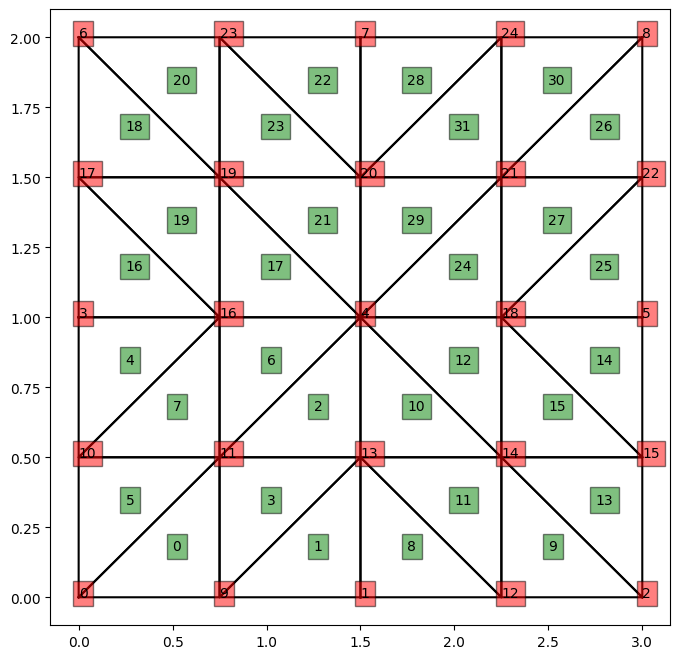

In [2]:
print("Maillage EF  ne: {}  nn: {}  tbc: {}  X: {}".format(G.ne,G.nn,G.Tbc.shape,G.X.shape))
plt.figure(figsize=(8,8))
G.plotmesh()
G.plotelt()
G.plotnds()
plt.show()

## Element de référence

Sur le l'élément de référence, définir les 3 fonctions de forme $P^1$: **N1, N2 et N3**

In [3]:
def N1(xsi,eta):
    ## BEGIN SOLUTION
    return 1-xsi-eta
    ## END SOLUTION
def N2(xsi,eta):
    ## BEGIN SOLUTION
    return xsi
    ## END SOLUTION
def N3(xsi,eta):
    ## BEGIN SOLUTION
    return eta
    ## END SOLUTION

In [4]:
# verification (valeur aux sommets)
assert np.abs(N1(0,0)-1.) < 1.e-8 and np.abs(N1(0,1)) < 1.e-8 and np.abs(N1(1,0)) < 1.e-8
assert np.abs(N2(0,0)) < 1.e-8 and np.abs(N2(0,1)) < 1.e-8 and np.abs(N2(1,0)-1.0) < 1.e-8
assert np.abs(N3(0,0)) < 1.e-8 and np.abs(N3(0,1)-1.0) < 1.e-8 and np.abs(N3(1,0)) < 1.e-8
printmd("### Validation OK")

### Validation OK

### Jacobienne
Ecrire une fonction Jacobienne, qui calcule la matrice J jacobienne de la transformation $(x,y)$ d'un élément k, vers l'élément de référence $(\xi,\eta)$:
$$ \left[\begin{array}{c} 
\xi\\
\eta
\end{array}\right]=J\left[\begin{array}{c}
x - x_0\\
y - y_0
\end{array}\right] $$
où $[x_0,y_0]$ sont les coordonnées du 1er sommet du triangle k. 

On passe comme argument le numéro de l'élément (à partir de 0) et la structure maillage G. 

In [5]:
def jacobienne(k,G):
    '''matrice jacobienne de l element k du maillage G'''
    ## BEGIN SOLUTION
    num = G.Tbc[k,:]
    x = [G.X[num[0],0],G.X[num[1],0],G.X[num[2],0]]
    y = [G.X[num[0],1],G.X[num[1],1],G.X[num[2],1]]
    s2 = (x[1]-x[0])*(y[2]-y[0]) - (x[2]-x[0])*(y[1]-y[0])
    J = np.array([[y[2]-y[0],x[0]-x[2]],[y[0]-y[1],x[1]-x[0]]])/s2
    return J
    ## END SOLUTION

In [6]:
# test elt k 
k = np.random.randint(G.ne)
print("element {} J:{}".format(k,jacobienne(k,G)))

element 29 J:[[ 1.33333333  0.        ]
 [-1.33333333  2.        ]]


In [7]:
# validation det J = 1/(2*surface ek)
k = np.random.randint(G.ne)
Jk = jacobienne(k,G)
assert np.abs(np.linalg.det(Jk) - (1/(2*_H_*_L_/G.ne))) < 1.e-8
printmd("### Validation OK")

### Validation OK

### Transformation
Ecrire une fonction **element** qui pour un point $(x,y)$ quelconque, renvoie l'élément k contenant le point ainsi ses coordonnées $(\xi,\eta)$ dans l'élément de référence.
Elle aura pour argument x,y et la structure G et devra renvoyée k,xi et eta: i.e.

        return k,xi,eta

ou si aucun élèment ne contient le point.

        return None,0,0
        
 La fonction devra utiliser la fonction jacobienne précédente.

In [8]:
def element(Xp,G):
    ''' détermine l elt k du maillage G contenant le point Xp=(x,y) '''
    ## BEGIN SOLUTION
    # precision
    eps = 1.e-5
    zero = -eps
    un   = 1+eps
    # element contenant Xp
    k  = None
    for p in range(G.ne):
        Jp = jacobienne(p,G)
        n0 = G.Tbc[p,0]
        # coordonnées barycentriques
        A  = np.dot(Jp,Xp-G.X[n0])
        A2 = 1 - A[0] - A[1]
        if (A[0]<zero) or (A[0]>un) or (A[1]<zero) or (A[1]>un) or (A2<zero) or (A2>un) : 
            continue
        # on a trouver l'element k
        return p,A[0],A[1]
    # fin de la boucle (x,y) n'est pas dans le maille
    return None,0,0
    ## END SOLUTION

In [9]:
# verification avec un noeud d'un elt 
k = np.random.randint(G.ne)
ke, xi,eta = element(G.X[G.Tbc[k,0]],G)
print("element {} = {} xi={} eta={}".format(k,ke,xi,eta))

element 4 = 4 xi=0.0 eta=0.0


In [10]:
# verification avec le milieu d'un element (doit renvoyer 1/3 1/3)
k = np.random.randint(G.ne)
num = G.Tbc[k,:]
X = (G.X[num[0]]+G.X[num[1]]+G.X[num[2]])/3.0
ke,xi,eta = element(X,G)
assert (k==ke) and (np.abs(xi-1./3) < 1.0e-4) and (np.abs(eta-1./3) < 1.0e-4)
# test utilisation de jacobienne
orig_jacobienne = jacobienne
del jacobienne
try:
    element(X,G)
except NameError as error:
    pass
else:
    raise AssertionError("erreur n'utilise pas la fonction jacobienne")
finally:
    jacobienne = orig_jacobienne  
printmd("### Validation OK")

### Validation OK

## Interpolation
Ecrire une fonction **interpol2D(Xp,F,G)** qui calcule l'interpolation P1 au point $Xp=[x,y]$ d'une fonction f(x) donnée par ses valeurs nodales $F = \{F_i=F(X_i)\}$ aux noeuds $i$ d'un maillage G.

La fonction devra utiliser la fonction **element** précédente et les fonctions de forme N1,N2,N3

In [11]:
def interpol2D(Xp,F,G):
    '''calcul interpolation au pt (x,y) a partir des valeurs nodales F sur un maillage G'''
    ## BEGIN SOLUTION
    k,xi,eta = element(Xp,G)
    if k==None: return None
    num = G.Tbc[k,:]
    return N1(xi,eta)*F[num[0]]+N2(xi,eta)*F[num[1]]+N3(xi,eta)*F[num[2]]
    ## END SOLUTION

In [12]:
# test fonction linéaire x+y en [1,1] (resultat 2.0)
Fp = G.X[:,0] + G.X[:,1]
print(interpol2D([1,1],Fp,G))

2.0


In [13]:
# test fonction lineaire
Fp = 2*G.X[:,0] + 3*G.X[:,1]
for x in np.linspace(0,_L_,5):
    for y in np.linspace(0,_H_,5):
        assert np.abs(interpol2D([x,y],Fp,G) - (2*x+3*y)) < 1.e-6
#test utilisation de element
orig_element = element
del element
try:
    interpol2D([1,1],Fp,G)
except NameError as error:
    pass
else:
    raise AssertionError("erreur n'utilise pas la fonction element")
finally:
    element = orig_element 
printmd("## Validation OK")

## Validation OK

## Analyse de la précision

Ecrire une fonction **ErreurInterp** qui calcule la norme de l'erreur d'interpolation (norme du max) entre une fonction f(x,y) et son interpolation sur un maillage G.

Le domaine etant rectangulaire, on prendra une vingtaine de points dans chaque direction pour le calcul de l'erreur.

In [14]:
def ErreurInterp(F,G):
    '''calcul erreur interpolation (norme du max) de la fonction F(x,y) sur un maillage G '''
    ## BEGIN SOLUTION
    Fp = F(G.X[:,0],G.X[:,1])
    errmax = 0.0
    for x in np.linspace(0,_L_,20):
        for y in np.linspace(0,_H_,20):
            err = np.abs(interpol2D([x,y],Fp,G)-F(x,y))
            if err > errmax: errmax = err
    return errmax
    ## END SOLUTION

In [16]:
# test fonction linéaire x+y  (resultat 0.0)
f = lambda x,y: x+y
err = ErreurInterp(f,G)
print("Erreur=",err)

Erreur= 8.881784197001252e-16


In [17]:
# test sur une fonction lineaire
f = lambda x,y: x+y
assert ErreurInterp(f,G) < 1.e-8
#test utilisation de element
orig_interpol2D = interpol2D
del interpol2D
try:
    ErreurInterp(f,G) 
except NameError as error:
    pass
else:
    raise AssertionError("erreur n'utilise pas la fonction interpol2D")
finally:
    interpol2D = orig_interpol2D
printmd("## Validation OK")

## Validation OK

## Precision
pour la fonction quadratique $f(x,y) = x^2 + y^2$, calculer l'erreur d'interpolation sur le maillage G,
puis sur le maillage G1 raffiné uniformement (taille des éléments divisée par2), puis encore sur un maillage G2 raffiné uniformement à partir de G1.

En calculant le taux de réduction de l'erreur en déduire une estimation de l'ordre de l'erreur d'interpolation.

In [18]:
f = lambda x,y : x*x + y*y
G1 = G.raffine()
G2 = G1.raffine()
## BEGIN SOLUTION
Err = np.zeros(3)
Err[0] = ErreurInterp(f,G)
Err[1] = ErreurInterp(f,G1)
Err[2] = ErreurInterp(f,G2)
print("taux de reduction : ",Err[0]/Err[1],Err[1]/Err[2])
## END SOLUTION

taux de reduction :  3.99999999999993 4.0


## Conclusion
écrire vos conclusions ci-dessous 

=== BEGIN ANSWER ===

=== END ANSWER ===

## FIN